# LV3 - Klasifikacija teksta pomoću strojnog učenja



## Ciljevi laboratorijske vježbe:


*   Pripremiti označene skupove podataka za klasifikaciju teksta
*   Trenirati klasifikator
*   Evaluirati performanse klasifikatora (točnost, preciznost, odziv)



## 1. Instalacija biblioteka

In [ ]:
from google.colab import files
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC
import re
import spacy
nlp = spacy.load("en_core_web_sm")
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline

## 2. Učitavanje dataseta Coronavirus tweets NLP - Text Classification

Potrebno je preuzeti javni dataset s platforme Kaggle. Kako bi preuzimanje bilo uspješno, potrebno je preuzeti datoteku `kaggle.json` sa svog Kaggle korisničkog profila i uploadati ju prilikom izvođenja sljedećeg programskog koda. Moguće je i preuzeti dataset i prenijeti ga u Google Colab ručno. Dataset možete preuzeti na [linku](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification).



In [ ]:
!unzip covid-19-nlp-text-classification.zip -d covid_dataset

# Ovaj dataset dolazi kodiran u ISO-8859-1 (Latin-1), pa je potrebno specificirati encoding parametar
train = pd.read_csv("sample_data/Corona_NLP_train.csv", encoding="latin1")
test = pd.read_csv("sample_data/Corona_NLP_test.csv", encoding="latin1")

train.head()

unzip:  cannot find or open covid-19-nlp-text-classification.zip, covid-19-nlp-text-classification.zip.zip or covid-19-nlp-text-classification.zip.ZIP.


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


## 3. Priprema podataka



### a) Odabir značajki

In [ ]:
selected_features_train = train[['OriginalTweet', 'Sentiment']]
selected_features_test = test[['OriginalTweet', 'Sentiment']]

### b) Provjera nedostajućih vrijednosti

In [ ]:
print(selected_features_train.shape[0])
print(f"Broj nedostajućih vrijednosti:\n{selected_features_train.isnull().sum()}")

41157
Broj nedostajućih vrijednosti:
OriginalTweet    0
Sentiment        0
dtype: int64


Budući da stupac Location neće biti korišten pri treniranju modela, nedostajuće vrijednosti se mogu zanemariti.

In [ ]:
print(selected_features_test.shape[0])
print(f"Broj nedostajućih vrijednosti u testnom skupu:\n{selected_features_test.isnull().sum()}")

3798
Broj nedostajućih vrijednosti u testnom skupu:
OriginalTweet    0
Sentiment        0
dtype: int64


In [ ]:
#ZADATAK: Provjerite broj ponavljanja svake od kategorija tweetova te ih prikžite na grafu koristeći prikladne biblioteke
selected_features_train['Sentiment'].value_counts()


,count
Sentiment,
Positive,11422
Negative,9917
Neutral,7713
Extremely Positive,6624
Extremely Negative,5481


In [ ]:
mapping = {
    'Positive': 'Positive',
    'Extremely Positive': 'Positive',
    'Negative': 'Negative',
    'Extremely Negative': 'Negative',
    'Neutral': 'Neutral'
}

selected_features_train['Sentiment'] = selected_features_train['Sentiment'].map(mapping)
selected_features_test['Sentiment'] = selected_features_test['Sentiment'].map(mapping)

#ZADATAK: Prikažite broj primjeraka u svakoj klasi nakon mapiranja
selected_features_test['Sentiment'].value_counts()


/tmp/ipython-input-1998319027.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_train['Sentiment'] = selected_features_train['Sentiment'].map(mapping)
/tmp/ipython-input-1998319027.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_test['Sentiment'] = selected_features_test['Sentiment'].map(mapping)


,count
Sentiment,
Negative,1633
Positive,1546
Neutral,619


### c) Lematizacija i čišćenje teksta

In [ ]:
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    if pd.isna(text):
        return ""
    words = text.split()
    lem_words = [lemmatizer.lemmatize(word.lower()) for word in words]
    return " ".join(lem_words)

selected_features_train['clean_tweet'] = selected_features_train['OriginalTweet'].apply(lemmatize_text).apply(clean_text)
selected_features_test['clean_tweet'] = selected_features_test['OriginalTweet'].apply(lemmatize_text).apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/tmp/ipython-input-3092702984.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_train['clean_tweet'] = selected_features_train['OriginalTweet'].apply(lemmatize_text).apply(clean_text)
/tmp/ipython-input-3092702984.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

### d) Pretvaranje teksta u vektore značajki (TF-IDF)

TF-IDF (Term Frequency–Inverse Document Frequency) je statistička metoda koja se koristi u obradi prirodnog jezika i pretraživanju informacija za procjenu koliko je određena riječ važna za jedan dokument u odnosu na veću zbirku dokumenata. TF-IDF kombinira dvije komponente:
1. Frekvencija pojma (TF): Mjeri koliko se puta riječ pojavljuje u dokumentu. Veća učestalost sugerira veću važnost. Ako se neki pojam često pojavljuje u dokumentu, vjerojatno je relevantan za sadržaj tog dokumenta.
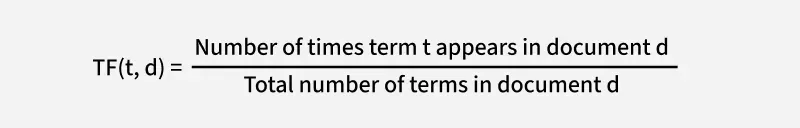

2. Obrnuta frekvencija dokumenta (IDF): Smanjuje težinu uobičajenih riječi koje se pojavljuju u više dokumenata, dok povećava težinu rijetkih riječi. Ako se pojam pojavljuje u manjem broju dokumenata, veća je vjerojatnost da je značajan i specifičan.
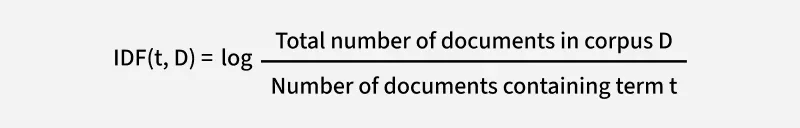

Ova ravnoteža omogućuje TF-IDF-u da istakne pojmove koji su i učestali unutar određenog dokumenta i prepoznatljivi u odnosu na ostatak zbirke dokumenata, što ga čini korisnim alatom za zadatke poput rangiranja pretraživanja, klasifikacije teksta i izdvajanja ključnih riječi.

In [ ]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

X_train = tfidf.fit_transform(selected_features_train['clean_tweet'])
#ZADATAK: Transformirati očišćene tekstualne tweetove u numeričku TF-IDF reprezentaciju na testnom skupu.
X_test = tfidf.transform(selected_features_test['clean_tweet'])


### e) Enkodiranje oznaka

In [ ]:
le = LabelEncoder()

print(selected_features_train['Sentiment'].unique())

y_train = le.fit_transform(selected_features_train['Sentiment'])
y_test = le.transform(selected_features_test['Sentiment'])

y_train = pd.DataFrame(y_train, columns=['Sentiment'])
y_test = pd.DataFrame(y_test, columns=['Sentiment'])
y_train.head()

['Neutral' 'Positive' 'Negative']


,Sentiment
0,1
1,2
2,2
3,2
4,0


## 4. Treniranje modela - Naive Bayes

In [ ]:
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(MultinomialNB(), param_grid, cv=skf, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best alpha:", grid.best_params_)
print("Best cross-val accuracy:", grid.best_score_)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Best alpha: {'alpha': 0.1}
Best cross-val accuracy: 0.6779407213880917


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [ ]:
model = MultinomialNB(alpha = 0.1)
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB(alpha=0.1)

## 5. Evaluacija performansi

In [ ]:
y_pred = model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

    Negative       0.72      0.72      0.72      1633
     Neutral       0.62      0.19      0.29       619
    Positive       0.64      0.81      0.71      1546

    accuracy                           0.67      3798
   macro avg       0.66      0.57      0.57      3798
weighted avg       0.67      0.67      0.65      3798

Confusion Matrix:

[[1177   47  409]
 [ 196  116  307]
 [ 271   24 1251]]


## ZADATAK:
Trenirati model koristeći SVM i usporediti performanse s Naive Bayes-om.

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Grid search za SVM
param_grid_svm = {
    'C': [0.01, 0.1, 1.0, 10.0]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_svm = GridSearchCV(
    LinearSVC(),
    param_grid_svm,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1
)

# Ako ti y_train i y_test stoje kao DataFrame:
grid_svm.fit(X_train, y_train['Sentiment'])

print("Best params (SVM):", grid_svm.best_params_)
print("Best cross-val accuracy (SVM):", grid_svm.best_score_)

# Treniranje finalnog SVM modela s najboljim parametrima
svm_model = LinearSVC(**grid_svm.best_params_)
svm_model.fit(X_train, y_train['Sentiment'])

# Predikcija na test skupu
y_pred_svm = svm_model.predict(X_test)

print("SVM Classification Report:\n")
print(classification_report(y_test['Sentiment'], y_pred_svm, target_names=le.classes_))

print("SVM Confusion Matrix:\n")
print(confusion_matrix(y_test['Sentiment'], y_pred_svm))


Best params (SVM): {'C': 1.0}
Best cross-val accuracy (SVM): 0.794251404329717
SVM Classification Report:

              precision    recall  f1-score   support

    Negative       0.81      0.78      0.79      1633
     Neutral       0.66      0.64      0.65       619
    Positive       0.80      0.84      0.82      1546

    accuracy                           0.78      3798
   macro avg       0.76      0.75      0.75      3798
weighted avg       0.78      0.78      0.78      3798

SVM Confusion Matrix:

[[1273  134  226]
 [ 125  397   97]
 [ 180   72 1294]]


# Zadatak – samostalan rad na datasetu

### U ovom zadatku studenti će sami proći cijeli proces klasifikacije teksta koristeći metode strojnog učenja – od pripreme podataka do treniranja i usporedbe različitih modela.

Cilj je klasificirati opise proizvoda iz e-trgovine u jednu od četiri kategorije (Electronics, Household, Books, Clothing & Accessories).

### Koraci zadatka:

1. **Pregled dataseta**  
   - Preuzmite dataset „E-commerce Text Classification“ s Kaggle-a:  
     https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification  
   - Učitajte ga u Colab (npr. pomoću `pd.read_csv`)  
   - Prikažite osnovne informacije o datasetu

2. **Odabir značajki i čišćenje podataka**  
   - Provjerite i obradite nedostajuće vrijednosti
   - Uklonite duplikate ako postoje  
   - Po potrebi uravnotežite dataset (npr. undersampling/oversampling) – nije obavezno, ali je plus

3. **Predobrada teksta (čišćenje i lematizacija)**  
   - Pretvorite tekst u mala slova  
   - Uklonite HTML tagove, URL-ove, interpunkciju, brojeve, specijalne znakove  
   - Uklonite stop-riječi  
   - Provedite lematizaciju

4. **Pretvaranje teksta u vektore značajki**  
     - `TfidfVectorizer`
   - Podijelite podatke na train/test skup (80/20 ili 75/25)

5. **Enkodiranje oznaka (labela)**  
   - Pretvorite tekstualne kategorije u brojčane pomoću `LabelEncoder` ili `OneHotEncoder` (ovisno o modelu)

6. **Treniranje i usporedba modela**  
   
   
   Za svaki model:
   - Naučite model na trening skupu
   - Izmjerite performanse na test skupu: **accuracy, precision, recall, F1-score**
   - Nacrtajte **confusion matrix** i **classification report**
   - Ako stignete: Podesite hiperparametre (barem `GridSearchCV` ili `RandomizedSearchCV` na 2–3 parametra) za bolje rezultate

7. **Vizualizacija rezultata**  
   - Usporedite dva (ili više) modela u tablici i stupčastim grafom (accuracy, F1-score)
   
   - Ako koristite TF-IDF, pokažite 10–20 riječi s najvećim TF-IDF težinama po klasi (Iz riječi biste trebali zaključiti o kojoj klasi se radi)

8. **Zaključak i komentar rezultata**  
   - Koji model je bio bolji i zašto?
   - Koje su prednosti i nedostaci pristupa koje ste koristili?
   - Što biste još mogli isprobati da poboljšate rezultat (ideje za daljnje eksperimente)?
   - Koliko je predobrada teksta utjecala na performanse?


In [ ]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# 1. Ucitavanje CSV-a bez headera
path = "sample_data/ecommerceDataset.csv"  # prilagodi putanju ako treba
df = pd.read_csv(path, header=None)

# Pretpostavka: 0 = kategorija, 1 = opis proizvoda
df.columns = ['Category', 'Description']

print("Prvih par redova:")
print(df.head())

print("\nOsnovne info:")
print(df.info())

print("\nBroj zapisa po kategoriji:")
print(df['Category'].value_counts())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Prvih par redova:
    Category                                        Description
0  Household  Paper Plane Design Framed Wall Hanging Motivat...
1  Household  SAF 'Floral' Framed Painting (Wood, 30 inch x ...
2  Household  SAF 'UV Textured Modern Art Print Framed' Pain...
3  Household  SAF Flower Print Framed Painting (Synthetic, 1...
4  Household  Incredible Gifts India Wooden Happy Birthday U...

Osnovne info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50425 entries, 0 to 50424
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Category     50425 non-null  object
 1   Description  50424 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB
None

Broj zapisa po kategoriji:
Category
Household                 19313
Books                     11820
Electronics               10621
Clothing & Accessories     8671
Name: count, dtype: int64


In [ ]:
# Provjera nedostajucih vrijednosti
print("Nedostajuce vrijednosti po stupcima:")
print(df.isnull().sum())

# Makni retke s NaN u ključnim stupcima
df = df.dropna(subset=['Category', 'Description'])

# Uklanjanje duplikata (isti opis + ista kategorija)
before = len(df)
df = df.drop_duplicates(subset=['Category', 'Description'])
after = len(df)
print(f"Uklonjeno duplikata: {before - after}")


Nedostajuce vrijednosti po stupcima:
Category       0
Description    1
dtype: int64
Uklonjeno duplikata: 22622


In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # lower
    text = text.lower()
    # makni HTML tagove
    text = re.sub(r'<.*?>', ' ', text)
    # makni URL-ove
    text = re.sub(r'http\\S+|www\\.\\S+', ' ', text)
    # makni brojeve
    text = re.sub(r'\\d+', ' ', text)
    # makni interpunkciju
    text = text.translate(str.maketrans('', '', string.punctuation))
    # makni specijalne znakove
    text = re.sub(r'[^a-zA-Z ]+', ' ', text)
    # višestruke razmake sreži
    text = re.sub(r'\\s+', ' ', text).strip()
    return text

def lemmatize_text(text):
    words = text.split()
    lem_words = []
    for w in words:
        if w in stop_words:
            continue
        lem_words.append(lemmatizer.lemmatize(w))
    return " ".join(lem_words)

# primjeni obradu
df['clean_text'] = df['Description'].apply(clean_text).apply(lemmatize_text)

print("Primjer prije/poslije:")
print(df[['Description', 'clean_text']].head())


Primjer prije/poslije:
                                         Description  \
0  Paper Plane Design Framed Wall Hanging Motivat...   
1  SAF 'Floral' Framed Painting (Wood, 30 inch x ...   
2  SAF 'UV Textured Modern Art Print Framed' Pain...   
3  SAF Flower Print Framed Painting (Synthetic, 1...   
4  Incredible Gifts India Wooden Happy Birthday U...   

                                          clean_text  
0  paper plane design framed wall hanging motivat...  
1  saf floral framed painting wood inch x inch sp...  
2  saf uv textured modern art print framed painti...  
3  saf flower print framed painting synthetic inc...  
4  incredible gift india wooden happy birthday un...  


In [ ]:
X = df['clean_text']
y = df['Category']

# Train/test split (80/20)
X_train_text, X_test_text, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Distribucija train labela:")
print(y_train_raw.value_counts())
print("\nDistribucija test labela:")
print(y_test_raw.value_counts())

# LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)

print("\nMapiranje labela:")
for i, c in enumerate(le.classes_):
    print(i, "->", c)


Distribucija train labela:
Category
Household                 8451
Books                     5005
Clothing & Accessories    4539
Electronics               4246
Name: count, dtype: int64

Distribucija test labela:
Category
Household                 2113
Books                     1251
Clothing & Accessories    1135
Electronics               1062
Name: count, dtype: int64

Mapiranje labela:
0 -> Books
1 -> Clothing & Accessories
2 -> Electronics
3 -> Household


In [ ]:
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2),   # unigrama + bigrama (možeš po želji smanjiti)
    min_df=2             # odbaci riječi koje se pojavljuju samo jednom
)

X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

print("Oblik X_train:", X_train.shape)
print("Oblik X_test:", X_test.shape)


Oblik X_train: (22241, 10000)
Oblik X_test: (5561, 10000)


In [ ]:
param_grid_nb = {'alpha': [0.1, 0.5, 1.0, 2.0]}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_nb = GridSearchCV(
    MultinomialNB(),
    param_grid_nb,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1
)

grid_nb.fit(X_train, y_train)

print("NB – best alpha:", grid_nb.best_params_)
print("NB – best CV accuracy:", grid_nb.best_score_)

nb_model = MultinomialNB(alpha=grid_nb.best_params_['alpha'])
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)

print("\n=== MultinomialNB – Classification report ===")
print(classification_report(y_test, y_pred_nb, target_names=le.classes_))

print("=== MultinomialNB – Confusion matrix ===")
print(confusion_matrix(y_test, y_pred_nb))


NB – best alpha: {'alpha': 0.1}
NB – best CV accuracy: 0.9397060066040221

=== MultinomialNB – Classification report ===
                        precision    recall  f1-score   support

                 Books       0.97      0.89      0.93      1251
Clothing & Accessories       0.96      0.97      0.97      1135
           Electronics       0.92      0.93      0.92      1062
             Household       0.92      0.96      0.94      2113

              accuracy                           0.94      5561
             macro avg       0.94      0.94      0.94      5561
          weighted avg       0.94      0.94      0.94      5561

=== MultinomialNB – Confusion matrix ===
[[1117   22   27   85]
 [   3 1104    3   25]
 [  13    2  983   64]
 [  18   24   51 2020]]


In [ ]:
param_grid_svm = {
    'C': [0.01, 0.1, 1.0, 10.0]
}

grid_svm = GridSearchCV(
    LinearSVC(),
    param_grid_svm,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1
)

grid_svm.fit(X_train, y_train)

print("SVM – best params:", grid_svm.best_params_)
print("SVM – best CV accuracy:", grid_svm.best_score_)

svm_model = LinearSVC(C=grid_svm.best_params_['C'])
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

print("\n=== SVM – Classification report ===")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

print("=== SVM – Confusion matrix ===")
print(confusion_matrix(y_test, y_pred_svm))


SVM – best params: {'C': 1.0}
SVM – best CV accuracy: 0.9549479431963533

=== SVM – Classification report ===
                        precision    recall  f1-score   support

                 Books       0.96      0.94      0.95      1251
Clothing & Accessories       0.98      0.98      0.98      1135
           Electronics       0.94      0.93      0.94      1062
             Household       0.95      0.96      0.96      2113

              accuracy                           0.96      5561
             macro avg       0.96      0.95      0.96      5561
          weighted avg       0.96      0.96      0.96      5561

=== SVM – Confusion matrix ===
[[1175   10   24   42]
 [   5 1114    4   12]
 [  14    3  991   54]
 [  30   12   36 2035]]


           Model  Accuracy  F1_weighted
0  MultinomialNB  0.939399     0.939288
1      LinearSVC  0.955763     0.955726


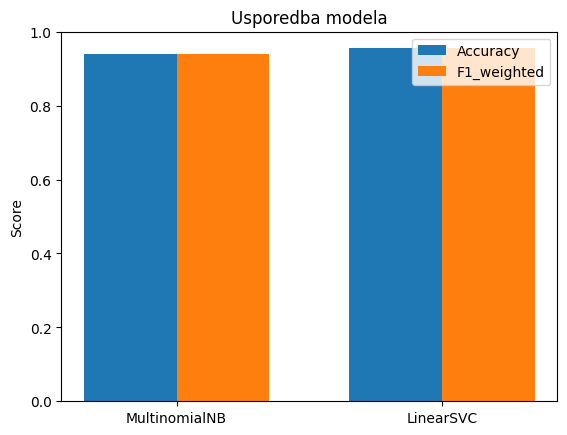

In [ ]:
results = []

acc_nb = accuracy_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb, average='weighted')

acc_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

results.append({'Model': 'MultinomialNB', 'Accuracy': acc_nb, 'F1_weighted': f1_nb})
results.append({'Model': 'LinearSVC', 'Accuracy': acc_svm, 'F1_weighted': f1_svm})

results_df = pd.DataFrame(results)
print(results_df)

# Stupčasti graf – usporedba Accuracy i F1
models = results_df['Model']
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, results_df['Accuracy'], width, label='Accuracy')
ax.bar(x + width/2, results_df['F1_weighted'], width, label='F1_weighted')

ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)
ax.set_ylabel('Score')
ax.set_title('Usporedba modela')
ax.legend()

plt.show()


In [ ]:
feature_names = np.array(vectorizer.get_feature_names_out())

def top_tfidf_words_per_class(X, y, label_encoder, top_n=15):
    for class_index, class_label in enumerate(label_encoder.classes_):
        # svi primjeri te klase
        class_mask = (y == class_index)
        X_class = X[class_mask]

        # prosjecni tf-idf za tu klasu
        mean_tfidf = np.asarray(X_class.mean(axis=0)).ravel()
        top_indices = mean_tfidf.argsort()[::-1][:top_n]
        top_words = feature_names[top_indices]

        print(f"\nTop {top_n} rijeci za klasu '{class_label}':")
        print(", ".join(top_words))

top_tfidf_words_per_class(X_train, y_train, le, top_n=15)



Top 15 rijeci za klasu 'Books':
book, author, review, university, life, new, student, world, story, india, exam, science, year, guide, time

Top 15 rijeci za klasu 'Clothing & Accessories':
cotton, men, womens, wear, girl, fit, fabric, boy, look, woman, size, made, soft, pack, sock

Top 15 rijeci za klasu 'Electronics':
camera, usb, cable, gb, mm, speaker, bluetooth, black, phone, device, laptop, audio, card, wireless, power

Top 15 rijeci za klasu 'Household':
set, steel, home, cm, product, stainless, stainless steel, table, use, color, easy, kitchen, inch, water, made


ZAKLJUČAK:

U ovom radu napravljen je cijeli proces izrade modela za klasifikaciju tekstualnih opisa proizvoda, od pripreme podataka do treniranja i usporedbe modela. Pokazalo se da je dobra obrada teksta jako bitna jer uklanjanje viška znakova i normalizacija riječi znatno pomažu modelima da bolje uče.

Usporedbom modela vidljivo je da Naive Bayes daje solidne rezultate uz brzu izvedbu, ali je Linear SVM precizniji i pouzdaniji za ovaj tip zadatka. Analiza TF-IDF značajki pokazala je da modeli uspješno prepoznaju ključne riječi karakteristične za pojedine kategorije proizvoda.

Rezultati su dobri, a model se može dodatno poboljšati isprobavanjem drugih pristupa ili podešavanjem parametara, što ostavlja prostor za daljnji rad.
